In [842]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import nnls
import networkx as nx



In [937]:
# Load model outputs
parameters_all = pandas.read_csv('seed vs. param op/Optimized param - version 9.csv')
# Current best version: 'Optimized param - with tmax2.csv'

seeding_all = pandas.read_csv('seed vs. param op/Optimized seed - version 9.csv')

# Load empirical data
ebm_data = pandas.read_csv('EBM stage + tau/Cross-sectional stage and regional tau - version 9.csv')

## Post Processing

In [938]:
# Eliminate subjects with beta > 0.0001
#rids_to_remove = parameters_all[parameters_all['beta'] == 0 ]['RID'] # SET HERE
#parameters_all= parameters_all[~parameters_all['RID'].isin(rids_to_remove)]
# seeding_nonzero = seeding_nonzero[~seeding_nonzero['RID'].isin(rids_to_remove)]
# ebm_nonzero = ebm_nonzero[~ebm_nonzero['RID'].isin(rids_to_remove)]
# ebm_nonzero = ebm_data
# seeding_nonzero = seeding_all
# parameters_nonzero = parameters_all
ebm_nonzero = ebm_data[ebm_data['Diagnosis'] != 'CN']
seeding_nonzero = seeding_all[seeding_all['Diagnosis'] != 'CN']
parameters_nonzero = parameters_all[parameters_all['Diagnosis'] != 'CN']


# Delete striatal regions in ebm data
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']
ebm_nonzero = ebm_nonzero.drop(columns=regions_to_exclude)

# Map diagnostic categories to numbers
# mapping = {'CN': 0, 'MCI': 1, 'Dementia': 2}
# parameters_nonzero['Diagnosis'] = parameters_nonzero['Diagnosis'].map(mapping) 
# ebm_nonzero['Diagnosis'] = ebm_nonzero['Diagnosis'].map(mapping) 
# seeding_nonzero['Diagnosis'] = seeding_nonzero['Diagnosis'].map(mapping) 

# Print value count for diagnostic categories
parameters_nonzero.Diagnosis.value_counts()


Diagnosis
MCI         196
Dementia     64
Name: count, dtype: int64

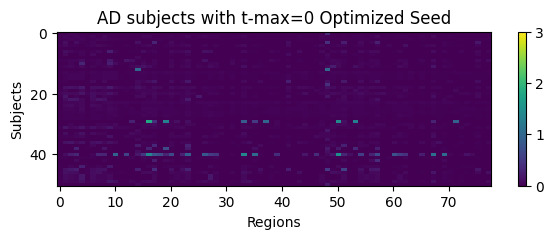

,Unnamed: 0,RID,Diagnosis,ml_stage,MSE,R,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Hippocampus,Left-Amygdala,...,ctx-rh-rostralanteriorcingulate,ctx-rh-rostralmiddlefrontal,ctx-rh-superiorfrontal,ctx-rh-superiorparietal,ctx-rh-superiortemporal,ctx-rh-supramarginal,ctx-rh-frontalpole,ctx-rh-temporalpole,ctx-rh-transversetemporal,ctx-rh-insula
0,0,21,0,0.0,0.019234,0.996878,0.017419,0.056632,0.082548,0.037614,...,0.024005,0.031657,0.018229,0.000000,0.029422,0.019397,0.030395,0.041296,0.021089,0.024626
1,1,31,0,0.0,0.007017,0.997238,0.012996,0.027688,0.037917,0.028997,...,0.017741,0.018396,0.018236,0.014209,0.012154,0.013019,0.011678,0.034804,0.014025,0.019367
2,2,56,1,0.0,0.025298,0.997549,0.009293,0.040703,0.037820,0.030646,...,0.017413,0.019406,0.014793,0.017065,0.022221,0.020257,0.013566,0.026875,0.012635,0.023394
3,3,59,1,0.0,0.030380,0.998371,0.008560,0.039073,0.053420,0.030653,...,0.013299,0.011270,0.009893,0.010275,0.016760,0.018186,0.013035,0.013731,0.014680,0.018340
4,4,69,1,2.0,0.007247,0.917322,0.025155,0.127488,0.029753,0.081364,...,0.009125,0.023744,0.041853,0.000000,0.000149,0.000000,0.000000,0.013399,0.000000,0.104420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,645,6704,1,1.0,0.006120,0.989523,0.015144,0.034598,0.034497,0.033303,...,0.015965,0.024597,0.016502,0.017917,0.011060,0.029637,0.007397,0.016708,0.020776,0.025033
646,646,6705,1,8.0,0.058794,0.388566,0.000000,0.000000,0.000277,0.000367,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
647,647,6713,0,0.0,0.017126,0.995027,0.015969,0.025969,0.083980,0.129529,...,0.010242,0.007995,0.000000,0.000000,0.019770,0.011076,0.000219,0.056873,0.000246,0.023228
648,648,6721,2,2.0,0.009628,0.948116,0.027447,0.068363,0.057010,0.049611,...,0.022192,0.033652,0.025943,0.000000,0.027122,0.000000,0.000000,0.015268,0.000000,0.080594


In [893]:
# TEMP: plot of problem subjects optimized seed tau

problem_subjects = [112, 142, 467, 626, 896, 1078, 1427, 2133, 2373, 2403, 4094, 4149, 4162, 4294, 4414, 4415, 4430, 4507, 4521, 4659, 4715, 4721, 4765, 4815, 4893, 4902, 4949, 4974, 6013, 6039, 6072, 6100, 6142, 6179, 6216, 6231, 6264, 6284, 6303, 6377, 6550, 6593, 6602, 6605, 6652, 6661, 6672, 6688, 6697, 6721, 6722]

seeding_nonzero_problem = seeding_nonzero[seeding_nonzero['RID'].isin(problem_subjects)]

plt.figure(figsize=(7, 2))
plt.imshow(seeding_nonzero_problem.iloc[:, 6:], cmap='viridis', interpolation='none', aspect='auto',vmin=-0, vmax=3)
plt.colorbar()  # Add a color bar to map colors to values
plt.title('AD subjects with t-max=0 Optimized Seed')
plt.xlabel('Regions')  # Replace with your actual label
plt.ylabel('Subjects')
plt.show()

seeding_nonzero

In [939]:
# Sort by diagnosis 
CN_param = parameters_nonzero[parameters_nonzero['Diagnosis'] == 'CN']
MCI_param = parameters_nonzero[parameters_nonzero['Diagnosis'] == 'MCI']
AD_param = parameters_nonzero[parameters_nonzero['Diagnosis'] == 'AD']
CN_by_stage_param = CN_param.sort_values(by='ml_stage')
MCI_by_stage_param = MCI_param.sort_values(by='ml_stage')
AD_by_stage_param = AD_param.sort_values(by='ml_stage')
parameters_by_diagnosis = pandas.concat([CN_by_stage_param, MCI_by_stage_param, AD_by_stage_param], ignore_index=True)

CN_seed = seeding_nonzero[seeding_nonzero['Diagnosis'] == 'CN']
MCI_seed = seeding_nonzero[seeding_nonzero['Diagnosis'] == 'MCI']
AD_seed = seeding_nonzero[seeding_nonzero['Diagnosis'] == 'AD']
CN_by_stage_seed = CN_seed.sort_values(by='ml_stage')
MCI_by_stage_seed = MCI_seed.sort_values(by='ml_stage')
AD_by_stage_seed = AD_seed.sort_values(by='ml_stage')
seeding_by_diagnosis = pandas.concat([CN_by_stage_seed, MCI_by_stage_seed, AD_by_stage_seed], ignore_index=True)

CN_ebm = ebm_nonzero[ebm_nonzero['Diagnosis'] == 'CN']
MCI_ebm = ebm_nonzero[ebm_nonzero['Diagnosis'] =='MCI']
AD_ebm = ebm_nonzero[ebm_nonzero['Diagnosis'] == 'AD']
CN_by_stage_ebm = CN_ebm.sort_values(by='ml_stage')
MCI_by_stage_ebm = MCI_ebm.sort_values(by='ml_stage')
AD_by_stage_ebm = AD_ebm.sort_values(by='ml_stage')
ebm_by_diagnosis = pandas.concat([CN_by_stage_ebm, MCI_by_stage_ebm, AD_by_stage_ebm], ignore_index=True)

# Calculate column means (overall and for each diagnositic category)
means_param = parameters_by_diagnosis.mean(numeric_only=True).to_frame().T
means_param_CN = CN_param.mean(numeric_only=True).to_frame().T
means_param_MCI = MCI_param.mean(numeric_only=True).to_frame().T
means_param_AD = AD_param.mean(numeric_only=True).to_frame().T
means_seed = seeding_by_diagnosis.mean(numeric_only=True).to_frame().T
means_seed_CN = CN_seed.mean(numeric_only=True).to_frame().T
means_seed_MCI = MCI_seed.mean(numeric_only=True).to_frame().T
means_seed_AD = AD_seed.mean(numeric_only=True).to_frame().T

# Parameter Optimization

   Unnamed: 0          RID  ml_stage      MSE         R     alpha      beta  \
0  302.561224  4744.852041  3.107143  0.38883  0.035707  0.546813  1.293957   

   gamma    s    b    p     k  
0    1.0  0.5  0.0  0.0  50.0  


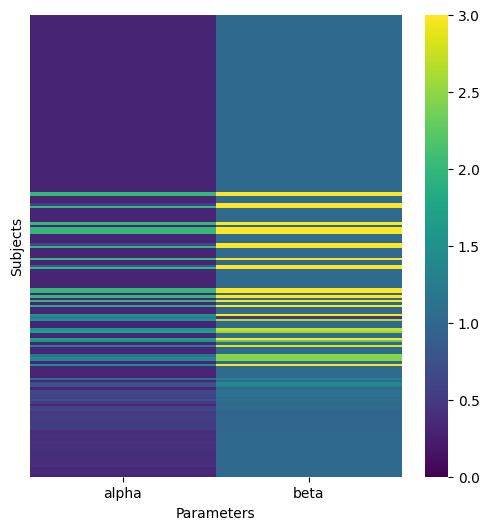

In [940]:
# Plot heat map of parameter values across subjects
plt.figure(figsize=(6, 6)) 
sns.heatmap(parameters_by_diagnosis.iloc[:,6:8], cmap='viridis', yticklabels=False, vmin=0, vmax=3) 
plt.xlabel('Parameters')
plt.ylabel('Subjects')
#plt.title('Parameters Across Subjects')

# Print average parameter values
print(means_param)

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_85443/1928209568.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.histplot(data=parameters_nonzero, bins = 30, x='alpha', color = 'red', hue='Diagnosis', palette=custom_purple_palette, multiple='stack')


(-0.1, 1.8)

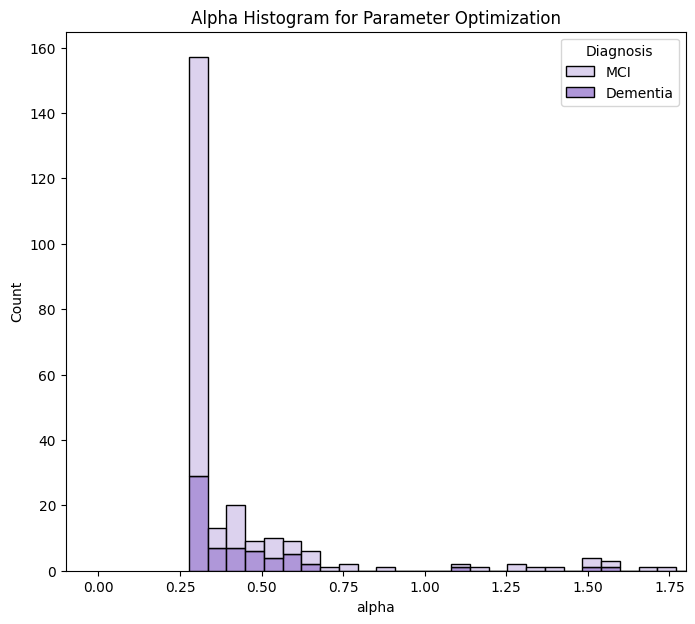

In [941]:
# Alpha histogram
custom_purple_palette = ['#d1c4e9', '#9575cd', '#512da8']
plt.figure(figsize=(8, 7))
ax = sns.histplot(data=parameters_nonzero, bins = 30, x='alpha', color = 'red', hue='Diagnosis', palette=custom_purple_palette, multiple='stack')
plt.title('Alpha Histogram for Parameter Optimization')
#plt.legend(title='Diagnosis')
plt.xlim(-0.1, 1.8)
#plt.ylim(0, 450)


/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_85443/1090730519.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.histplot(data=parameters_nonzero, bins = 35, x='beta', color = 'red',hue='Diagnosis', palette=custom_purple_palette, multiple='stack')


(0.0, 3.0)

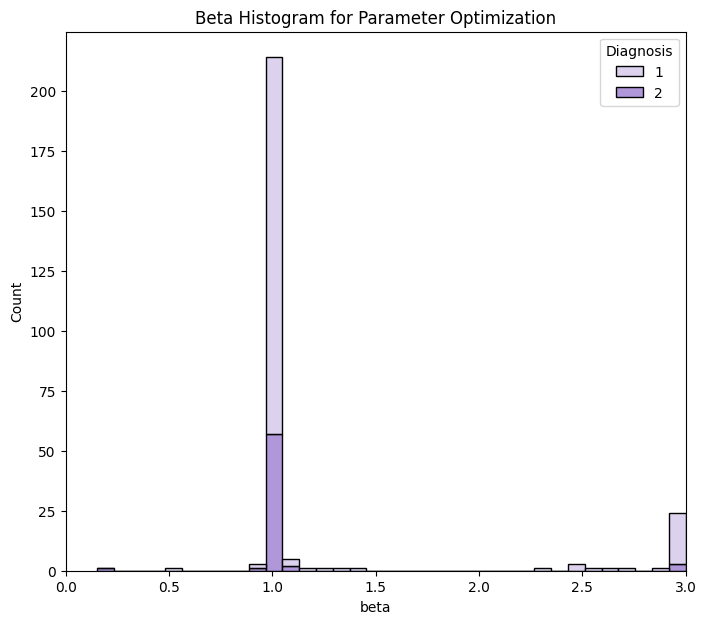

In [922]:
# Beta histogram
plt.figure(figsize=(8, 7))
ax = sns.histplot(data=parameters_nonzero, bins = 35, x='beta', color = 'red',hue='Diagnosis', palette=custom_purple_palette, multiple='stack')
plt.title('Beta Histogram for Parameter Optimization')
plt.xlim(0, 3)
#plt.ylim(0, 450)

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_85443/329790725.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.histplot(data=parameters_nonzero, bins = 30, x='MSE', color = 'red', hue='Diagnosis', palette=custom_purple_palette, multiple='stack',legend=True)


(0.0, 3.5)

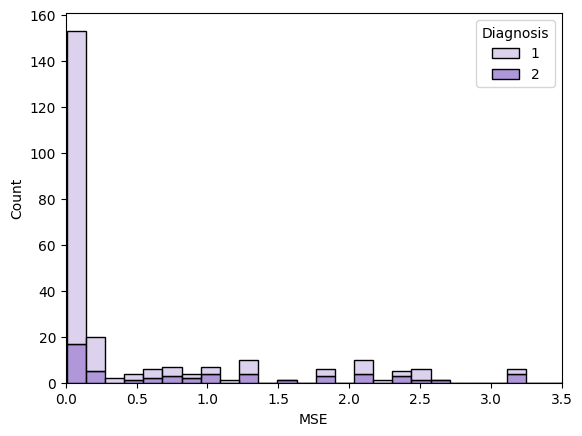

In [924]:
# Create histogram of MSE 
ax = sns.histplot(data=parameters_nonzero, bins = 30, x='MSE', color = 'red', hue='Diagnosis', palette=custom_purple_palette, multiple='stack',legend=True)
plt.xlabel('MSE')
plt.ylabel('Count')
#plt.title('MSE Histogram for Parameter Optimization')
plt.xlim(0, 3.5)
#plt.ylim(0, 500)

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_85443/3672176884.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.histplot(data=parameters_nonzero, bins = 15, x='R', color = 'red', hue='Diagnosis', palette=custom_purple_palette, multiple='stack',legend=True)


(-0.2, 1.0)

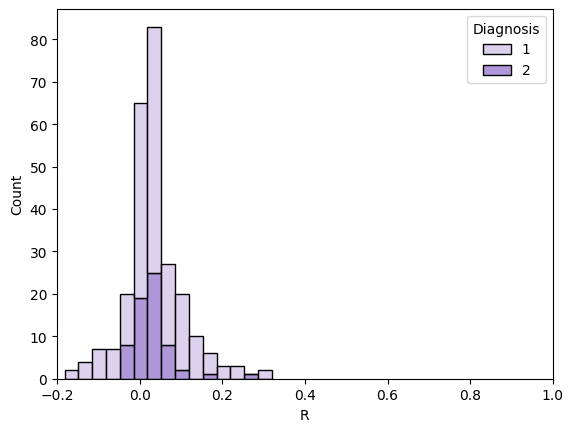

In [925]:
# Histogram for R
ax = sns.histplot(data=parameters_nonzero, bins = 15, x='R', color = 'red', hue='Diagnosis', palette=custom_purple_palette, multiple='stack',legend=True)
plt.xlabel('R')
plt.ylabel('Count')
#plt.title('R Histogram for Parameter Optimization')
plt.xlim(-0.2, 1)
#plt.ylim(0, 500)

# Seed Optimization

Regions with highest average tau seed density: ['ctx-rh-entorhinal', 'Left-VentralDC', 'ctx-lh-middletemporal', 'Left-Thalamus-Proper', 'Right-VentralDC', 'ctx-rh-inferiortemporal', 'ctx-lh-inferiortemporal', 'Left-Hippocampus', 'ctx-lh-entorhinal', 'ctx-rh-middletemporal', 'Left-Amygdala', 'Right-Thalamus-Proper', 'Right-Amygdala', 'ctx-lh-fusiform', 'ctx-rh-inferiorparietal', 'ctx-rh-lateralorbitofrontal', 'ctx-lh-lateralorbitofrontal', 'Right-Hippocampus', 'ctx-lh-precuneus', 'ctx-rh-fusiform', 'ctx-lh-inferiorparietal', 'ctx-lh-bankssts', 'ctx-rh-bankssts', 'ctx-rh-precuneus', 'ctx-lh-temporalpole', 'ctx-rh-parsorbitalis', 'ctx-rh-medialorbitofrontal', 'ctx-rh-rostralmiddlefrontal', 'ctx-lh-rostralmiddlefrontal', 'ctx-rh-lateraloccipital', 'ctx-lh-medialorbitofrontal', 'ctx-rh-cuneus', 'ctx-lh-parsorbitalis', 'ctx-rh-parstriangularis', 'ctx-rh-temporalpole', 'ctx-rh-posteriorcingulate', 'ctx-lh-posteriorcingulate', 'ctx-lh-cuneus', 'ctx-lh-parstriangularis', 'ctx-lh-insula', 'ctx-r

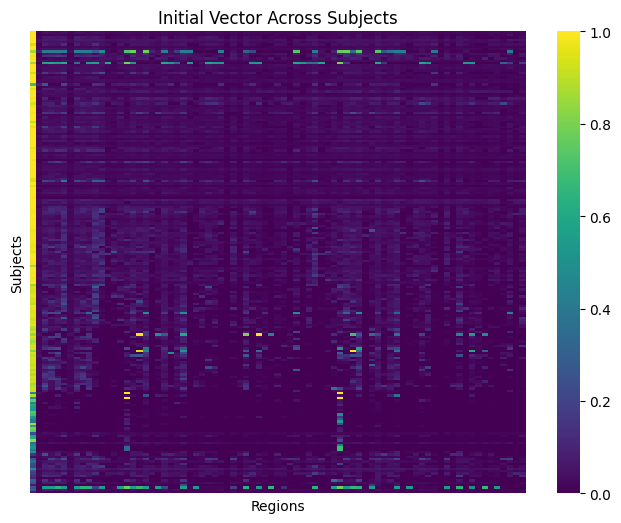

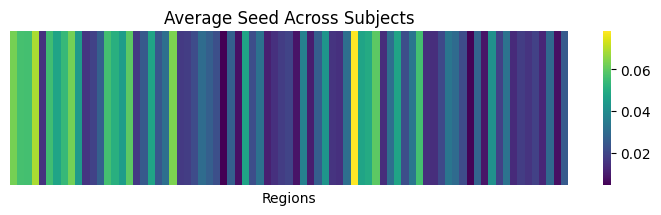

In [942]:
# Plot heat map of seeds across subjects
plt.figure(figsize=(8, 6)) 
sns.heatmap(seeding_by_diagnosis.iloc[:,5:], cmap='viridis', xticklabels=False, yticklabels=False, vmin=0, vmax=1)
plt.xlabel('Regions')
plt.ylabel('Subjects')
plt.title('Initial Vector Across Subjects')

# Plot average seed 
plt.figure(figsize=(9, 2)) 
sns.heatmap(means_seed.iloc[:, 6:], cmap='viridis', xticklabels=False, yticklabels=False)
plt.xlabel('Regions')
plt.title('Average Seed Across Subjects')

#Sort regions by highest averages and print
sorted_regions = means_seed.iloc[:, 6:].sort_values(by=0, axis=1, ascending=False)
sorted_regions = sorted_regions.columns.tolist()
print('Regions with highest average tau seed density: ' + str(sorted_regions))


Text(0.5, 1.0, 'MSE Histogram for Seed Optimization')

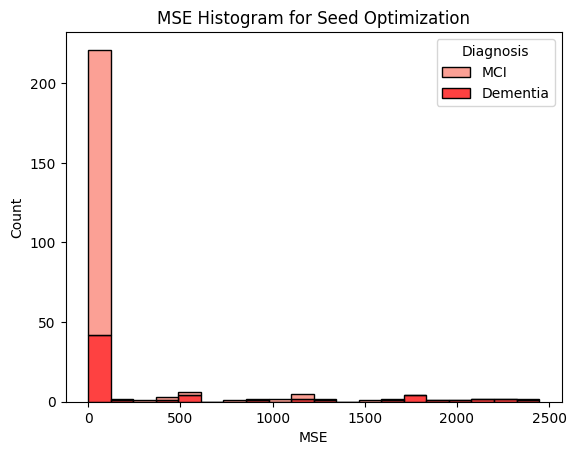

In [946]:
# Create histogram of MSE 
color_palette = {
    'Dementia': '#FE0101',  # Deep red
    'MCI': '#FA8072',  # Salmon
    'CN': '#F5F5DC'}   # Beige (light beige)

ax = sns.histplot(data=seeding_nonzero, bins = 20, x='MSE', color = 'red', hue='Diagnosis', palette=color_palette, multiple='stack',legend=True)
plt.xlabel('MSE')
plt.ylabel('Count')
plt.title('MSE Histogram for Seed Optimization')

#plt.xlim(0, 3.5)
#plt.ylim(0, 700)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('')
# ax.set_ylabel('')

(0.0, 1.0)

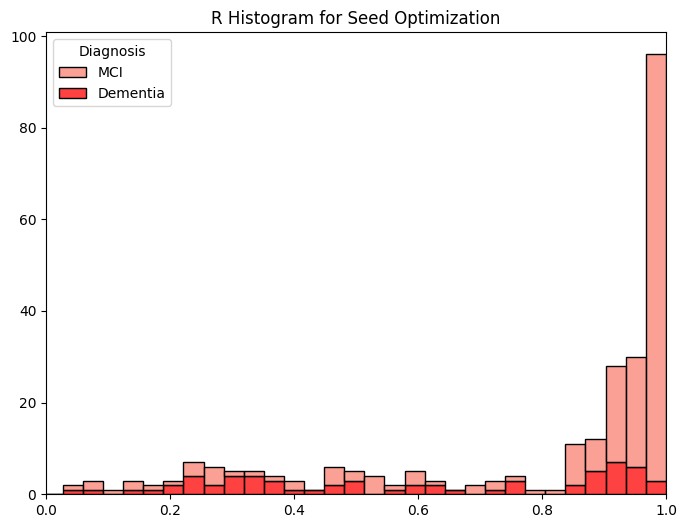

In [948]:
# Histogram of R 

plt.figure(figsize=(8, 6)) 
ax = sns.histplot(data=seeding_nonzero, bins = 40, x='R', color = 'red', hue='Diagnosis', palette=color_palette, multiple='stack',legend=True)
plt.xlabel('')
plt.ylabel('')
plt.title('R Histogram for Seed Optimization')
plt.xlim(0, 1)
#plt.ylim(0, 400)
# plt.gca().set_xticklabels([])
# plt.gca().set_yticklabels([])

## Means and Variance

In [949]:
# Define mean MSE and Pearson's R for param op
print("Parameter Optimization:")

# Overall
mean_mse_param = means_param['MSE'].iloc[0]
print('Mean MSE Overall: ' + str(mean_mse_param))
mean_R_param = means_param['R'].iloc[0]
print('Mean R Overall: ' + str(mean_R_param))

# By diagnostic category 
mean_mse_param_CN = means_param_CN['MSE'].iloc[0]
print('Mean MSE CN: ' + str(mean_mse_param_CN))
mean_R_param_CN = means_param_CN['R'].iloc[0]
print('Mean R CN: ' + str(mean_R_param_CN))
mean_mse_param_MCI = means_param_MCI['MSE'].iloc[0]
print('Mean MSE MCI: ' + str(mean_mse_param_MCI))
mean_R_param_MCI = means_param_MCI['R'].iloc[0]
print('Mean R MCI: ' + str(mean_R_param_MCI))
mean_mse_param_AD = means_param_AD['MSE'].iloc[0]
print('Mean MSE AD: ' + str(mean_mse_param_AD))
mean_R_param_AD = means_param_AD['R'].iloc[0]
print('Mean R AD: ' + str(mean_R_param_AD))

print("     ")

# Define mean MSE and Pearson's R for seed op
print("Seed Optimization:")

# Overall
mean_mse_seed = means_seed['MSE'].iloc[0]
print('Mean MSE Overall: ' + str(mean_mse_seed))
mean_R_seed = means_seed['R'].iloc[0]
print('Mean R Overall: ' + str(mean_R_seed))

# By diagnostic category 
mean_mse_seed_CN = means_seed_CN['MSE'].iloc[0]
print('Mean MSE CN: ' + str(mean_mse_seed_CN))
mean_R_seed_CN = means_seed_CN['R'].iloc[0]
print('Mean R CN: ' + str(mean_R_seed_CN))
mean_mse_seed_MCI = means_seed_MCI['MSE'].iloc[0]
print('Mean MSE MCI: ' + str(mean_mse_seed_MCI))
mean_R_seed_MCI = means_seed_MCI['R'].iloc[0]
print('Mean R MCI: ' + str(mean_R_seed_MCI))
mean_mse_seed_AD = means_seed_AD['MSE'].iloc[0]
print('Mean MSE AD: ' + str(mean_mse_seed_AD))
mean_R_seed_AD = means_seed_AD['R'].iloc[0]
print('Mean R AD: ' + str(mean_R_seed_AD))

# Print means for each diagnostic category 

Parameter Optimization:
Mean MSE Overall: 0.38882956560268844
Mean R Overall: 0.03570697215028159
Mean MSE CN: nan
Mean R CN: nan
Mean MSE MCI: 0.38882956560268855
Mean R MCI: 0.0357069721502816
Mean MSE AD: nan
Mean R AD: nan
     
Seed Optimization:
Mean MSE Overall: 85.53102428577533
Mean R Overall: 0.8465530457070383
Mean MSE CN: nan
Mean R CN: nan
Mean MSE MCI: 85.53102428577533
Mean R MCI: 0.8465530457070383
Mean MSE AD: nan
Mean R AD: nan


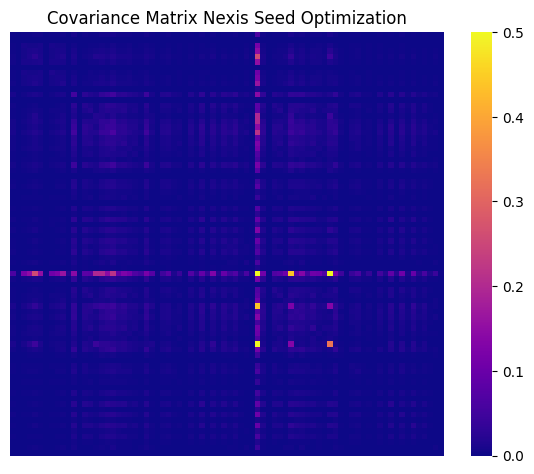

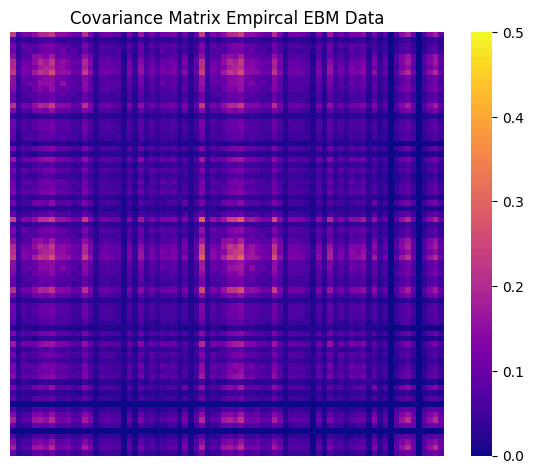

In [671]:
# Convert relevant columns to numeric, coercing errors to NaN
seeding_nonzero.iloc[:, 6:] = seeding_nonzero.iloc[:, 6:].apply(pandas.to_numeric, errors='coerce')
ebm_nonzero.iloc[:, 4:] = ebm_nonzero.iloc[:, 4:].apply(pandas.to_numeric, errors='coerce')

# Check for NaN values and handle them (e.g., fill with 0 or remove rows)
seeding_nonzero = seeding_nonzero.dropna(subset=seeding_nonzero.columns[6:], how='any')
ebm_nonzero = ebm_nonzero.dropna(subset=ebm_nonzero.columns[4:], how='any')

# Initialize the sum matrices
n = len(seeding_nonzero) # Number of subjects
Sum_model = np.zeros((78, 78))
Sum_ebm = np.zeros((78, 78))

# Loop through all subjects
for i in range(len(seeding_nonzero)):
    x_i = seeding_nonzero.iloc[i, 6:].values.astype(np.float64)  # Ensure the values are float64
    M_i = np.outer(x_i, x_i)
    Sum_model += M_i

    x_i_ebm = ebm_nonzero.iloc[i, 4:].values.astype(np.float64)  # Ensure the values are float64
    M_i_ebm = np.outer(x_i_ebm, x_i_ebm)
    Sum_ebm += M_i_ebm

# Compute the average
E_model = Sum_model / n
E_ebm= Sum_ebm / n

plt.figure(figsize=(7, 5.5)) 
sns.heatmap(E_model, cmap='plasma', vmin=0, vmax=0.5, xticklabels=False, yticklabels=False)
plt.title('Covariance Matrix Nexis Seed Optimization')

plt.figure(figsize=(7, 5.5)) 
sns.heatmap(E_ebm, cmap='plasma', vmin=0, vmax=0.5, xticklabels=False, yticklabels=False)
plt.title('Covariance Matrix Empircal EBM Data')

# Take the diagonal of both plot on PySurfer
Variance_model = np.diag(E_model)
Variance_ebm= np.diag(E_ebm)

# SVD and EVD for E_model matrix
U_model, S_model, VT_model = np.linalg.svd(E_model)
eigenvalues_model, eigenvectors_model = np.linalg.eig(E_model)

# SVD and EVD for E_ebm matrix
U_ebm, S_ebm, VT_ebm = np.linalg.svd(E_ebm)
eigenvalues_ebm, eigenvectors_ebm = np.linalg.eig(E_ebm)


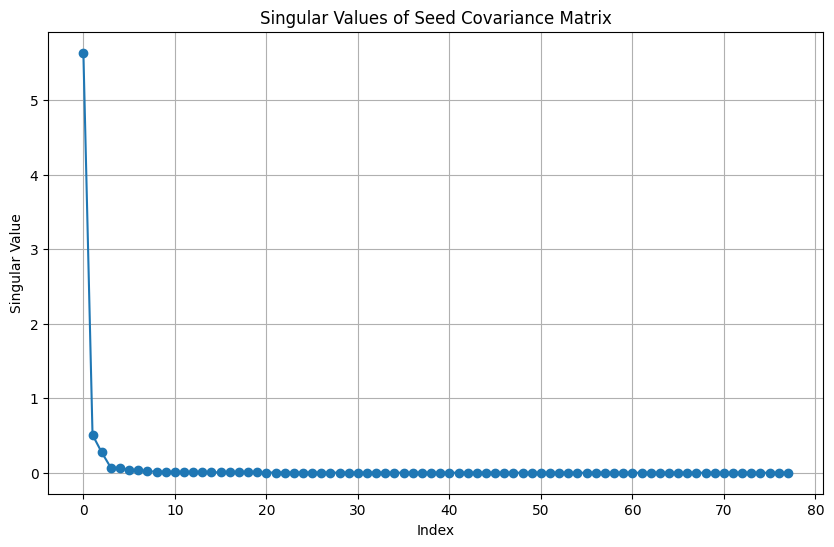

In [672]:
# Plot the singular values of E_model
plt.figure(figsize=(10, 6))
plt.plot(S_model, marker='o', linestyle='-')
plt.title('Singular Values of Seed Covariance Matrix')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

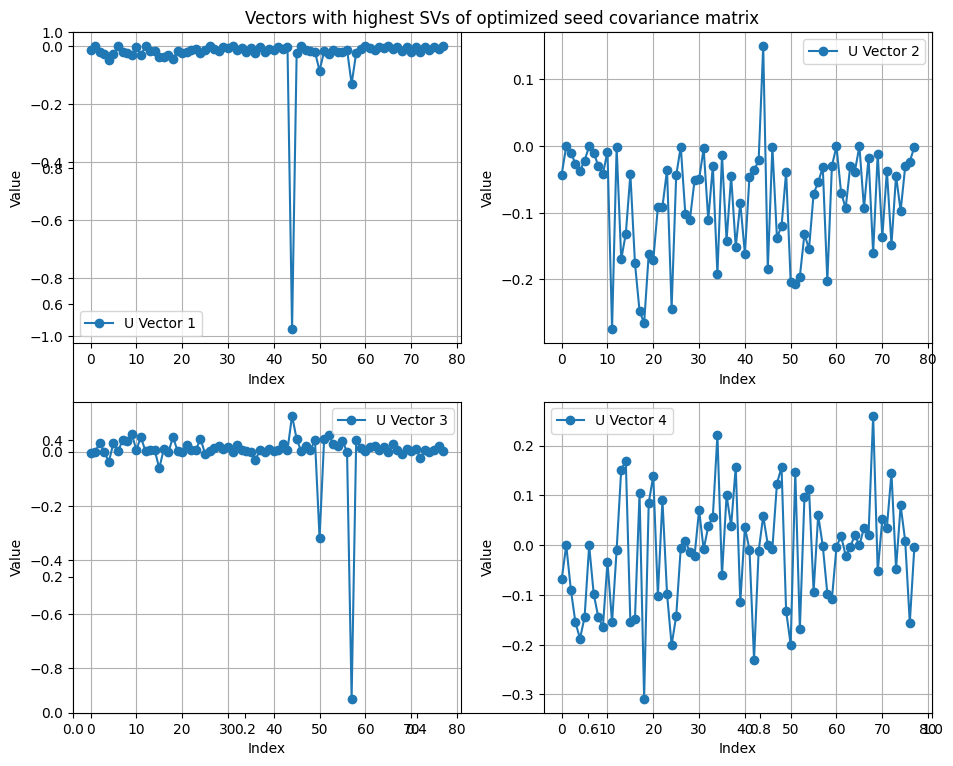

In [673]:
sorted_indices = np.argsort(S_model)[::-1]
sorted_singular_values = S_model[sorted_indices]
sorted_U = U_model[:, sorted_indices]

# Select top 4 vectors in U corresponding to highest SVs
top_U_vectors = sorted_U[:, :4]

# Plot the top 4 vectors in U
plt.figure(figsize=(10, 8))
plt.title('Vectors with highest SVs of optimized seed covariance matrix')
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(top_U_vectors[:, i], marker='o', linestyle='-', label=f'U Vector {i+1}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

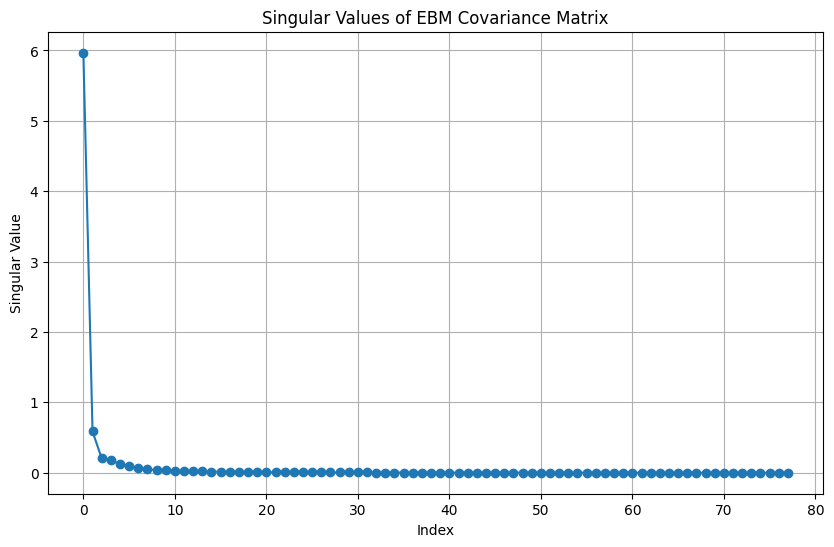

In [674]:
# Plot the singular values of E_ebm
plt.figure(figsize=(10, 6))
plt.plot(S_ebm, marker='o', linestyle='-')
plt.title('Singular Values of EBM Covariance Matrix')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()

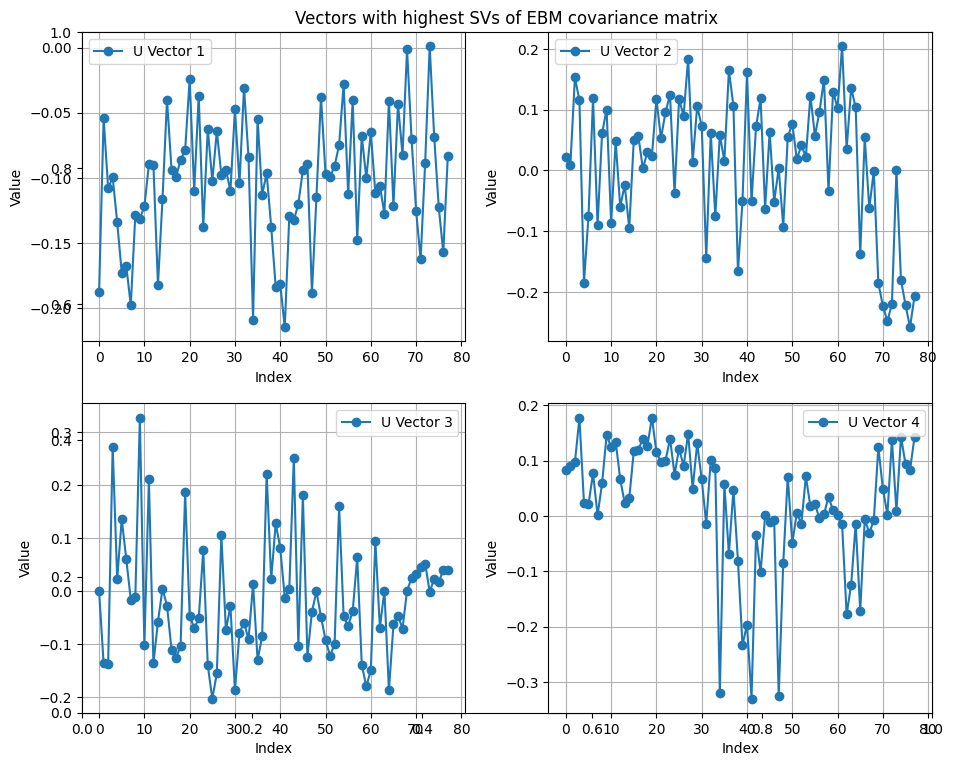

In [675]:
sorted_indices = np.argsort(S_ebm)[::-1]
sorted_singular_values = S_ebm[sorted_indices]
sorted_U = U_ebm[:, sorted_indices]

# Select top 4 vectors in U corresponding to highest SVs
top_U_vectors = sorted_U[:, :4]

# Plot the top 4 vectors in U
plt.figure(figsize=(10, 8))
plt.title('Vectors with highest SVs of EBM covariance matrix')
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(top_U_vectors[:, i], marker='o', linestyle='-', label=f'U Vector {i+1}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [279]:
# Save to csv to visualize with PySurfer

column_names = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate',	'ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal',	'ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus','ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']
Variance_model_df = pandas.DataFrame(columns=column_names)
Variance_model_df = pandas.concat([Variance_model_df, pandas.DataFrame([Variance_model], columns=column_names)], ignore_index=True)
Variance_model_df.to_csv('Model Seed Op Variance - lambda 0.009.csv')

column_names = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate',	'ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal',	'ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus','ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']
Variance_ebm_df = pandas.DataFrame(columns=column_names)
Variance_ebm_df = pandas.concat([Variance_ebm_df, pandas.DataFrame([Variance_ebm], columns=column_names)], ignore_index=True)
Variance_ebm_df.to_csv('EBM Variance - lambda 0.009.csv')

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_85443/4006384909.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Variance_model_df = pandas.concat([Variance_model_df, pandas.DataFrame([Variance_model], columns=column_names)], ignore_index=True)
/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_85443/4006384909.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Variance_ebm_df = pandas.concat([Variance_ebm_df, pandas.DataFrame([Variance_ebm], columns=column_names)], igno

## Calcuating AIC

In [782]:
seeding_length = len(seeding_nonzero)
parameters_length = len(parameters_nonzero)

# Use the smaller length to avoid out-of-bounds errors
min_length = min(seeding_length, parameters_length)

# Number of parameters being optimized
k_param = 3 # alpha, beta, gamma
k_seed = 6 # top 6 seeds

# Number of observations
n = len(seeding_nonzero)

# Compute the log-likelihood for both models
log_likelihoods_param = []
log_likelihoods_seed = []


for i in range(min_length): # for every subject
    subject_param = parameters_nonzero.iloc[i]
    log_likelihood_param = n / 2 * np.log(subject_param['R'] ** 2)
    log_likelihoods_param.append(log_likelihood_param)

    subject_seed = seeding_nonzero.iloc[i]
    log_likelihood_seed = n / 2 * np.log(subject_seed['R'] ** 2)
    log_likelihoods_seed.append(log_likelihood_seed)

# Sum log likelihoods across all subjects for both models
log_likelihoods_param = np.array(log_likelihoods_param)
log_total_param = log_likelihoods_param.sum()
log_likelihoods_seed = np.array(log_likelihoods_seed)
log_total_seed = log_likelihoods_seed.sum()

# Calculate AIC for both models
AIC_param = -2 * log_total_param + 2 * k_param
AIC_seed = -2 * log_total_seed + 2 * k_seed

print('AIC parameter optimization: ' + str(AIC_param))
print('AIC seed optimization: ' + str(AIC_seed))

AIC parameter optimization: 450075.8494918656
AIC seed optimization: 29775.251982241884
